GitHub Repository:
https://github.com/DataChemE/Cats_unsupervised

# How to Train Your Cat with Python

## Project Overview
This project leverages unsupervised learning techniques to cluster images of my two cats, Toast and Mena. Each cat's images are stored in separate folders named after them. The images vary in size and orientation, reflecting the diverse scenarios in which they were captured.

## Objective
The primary goal is to automatically cluster the images into two distinct groups, each corresponding to one of the cats. This involves using unsupervised learning methods to differentiate between the visual characteristics of Toast and Mena. This type of approach could be useful for organizing large image datasets or identifying patterns in unlabeled data, or just to organize your cat photos.

## Workflow
The project is structured into several key phases:
- **Data Collection**: Gathering and organizing the images.
- **Data Preprocessing**: Standardizing the images to a uniform size and format.
- **Feature Extraction**: Utilizing a pre-trained neural network to extract relevant features from each image.
- **Dimensionality Reduction**: Reducing the feature set to a manageable size for clustering.
- **Clustering**: Applying clustering algorithms to group the images based on extracted features.
- **Evaluation**: Assessing the effectiveness of the clustering approach.
- **Iteration and Refinement**: Making necessary adjustments to improve the model's performance.
- **Choosing the best model**: Selecting the best model based on evaluation metrics.
- **Conclusion**: Summarizing the results and potential future work.

## Expected Outcomes
By the end of this project, the model should be able to accurately distinguish between images of Toast and Mena, demonstrating the feasibility of using unsupervised machine learning techniques for image based clustering in a personal dataset.


# Data Collection

## Overview
The dataset comprises images of my two cats, Mena and Toast, captured using my phone over several years. These images serve as the primary data source for the project. 

**Since these images are my own private images, the repository will not contain the original data. We will only be showing example images in the notebook.**

## Image Characteristics
- **Size and Orientation**: The images vary in both size and orientation.
- **Cropping**: Each image has been individually cropped to ensure only one cat appears per image, aiding in more accurate analysis and model training.

## Organization
- **Storage**: All images are organized within the `cats` directory, split into two subdirectories named after each cat. 
**The images will not be in the Github repository, due to being personal/private images. We will be showing only example images in this notebook.**

- **Folders**:
  - `./cats/Mena`: Contains 181 images of Mena.
  - `./cats/Toast`: Contains 215 images of Toast.

## Total Images
- **Count**: The entire collection consists of 396 images, providing adequate dataset for machine learning purposes.


In [1]:
# Import all the necessary libraries for the project
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import local_binary_pattern
from skimage import io
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


# Data preprocessing

The images are all different sizes and orientations. The images first need to be pre-processed to be compatible with our feature extaction and clustering algorithms. Here is a summary of the function below. 

#### Function `preprocess_image`
- **Parameters**:
  - `image_path`: The path to the image file.
  - `target_size`: The desired size of the output image (224x224 pixels).
- **Process**:
  - Reads an image from the specified path.
  - Checks if the image is loaded successfully; if not, it prints an error message and returns `None`.
  - Resizes the image to `target_size`.
  - Converts the image color from BGR to RGB.
  - Applies predefined preprocessing suitable for ResNet models.
- **Returns**: The preprocessed image.

#### Image Preprocessing Steps
- Initializes lists for storing preprocessed images, their paths, and labels.
- Iterates over specified subdirectories ('toast' and 'mena') within a base folder (`./cats`).
- Reads, preprocesses, and stores each image along with its path and label in respective lists.
- Converts the list of preprocessed images into a numpy array for further processing.


In [2]:
def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image

target_size = (224, 224)  
preprocessed_images = []
image_paths = []
labels = []

base_folder = './cats'

for folder in ['toast', 'mena']:
    folder_path = os.path.join(base_folder, folder)
    for filename in os.listdir(folder_path):
        if not filename.startswith('.'):
            image_path = os.path.join(folder_path, filename)
            preprocessed_image = preprocess_image(image_path, target_size)
            if preprocessed_image is not None:
                preprocessed_images.append(preprocessed_image)
                image_paths.append(image_path)
                labels.append(folder)

preprocessed_images = np.array(preprocessed_images)

### Let's show you some cats!

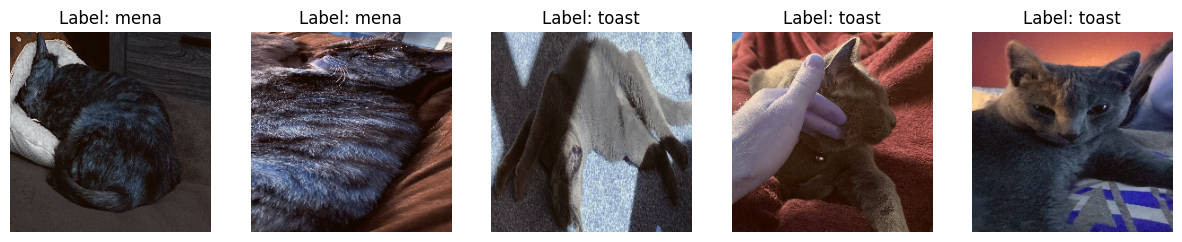

In [3]:
def display_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        
        display_image = (images[i] - images[i].min()) / (images[i].max() - images[i].min())
        ax.imshow(display_image)
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
    plt.show()

# Randomly select images to display
indices = np.random.choice(range(len(preprocessed_images)), 5, replace=False)
sample_images = preprocessed_images[indices]
sample_labels = [labels[i] for i in indices]

display_images(sample_images, sample_labels)

# EDA of the preprocessed images

Before we proceed with feature extraction, we will visualize characteristics of our preprocessed images. This will help us understand the data better and identify any potential issues that need to be addressed.

We will be exploring several aspects of the preprocessed images, including:
- **Image Size Distribution**: Analyzing the distribution of the original image sizes to understand how the resizing process affected them.
- **Color Channel Distributions**: Examining the distribution of pixel values across color channels.
- **Pixel intensity Distribution**: Investigating the distribution of pixel intensities in the images.
- **Outlier Detection**: Identifying any outliers in the dataset for pixel intensities.
- **Texture Analysis**: Visualizing the texture of the images using the gray-scale representation.

### Image size Distribution

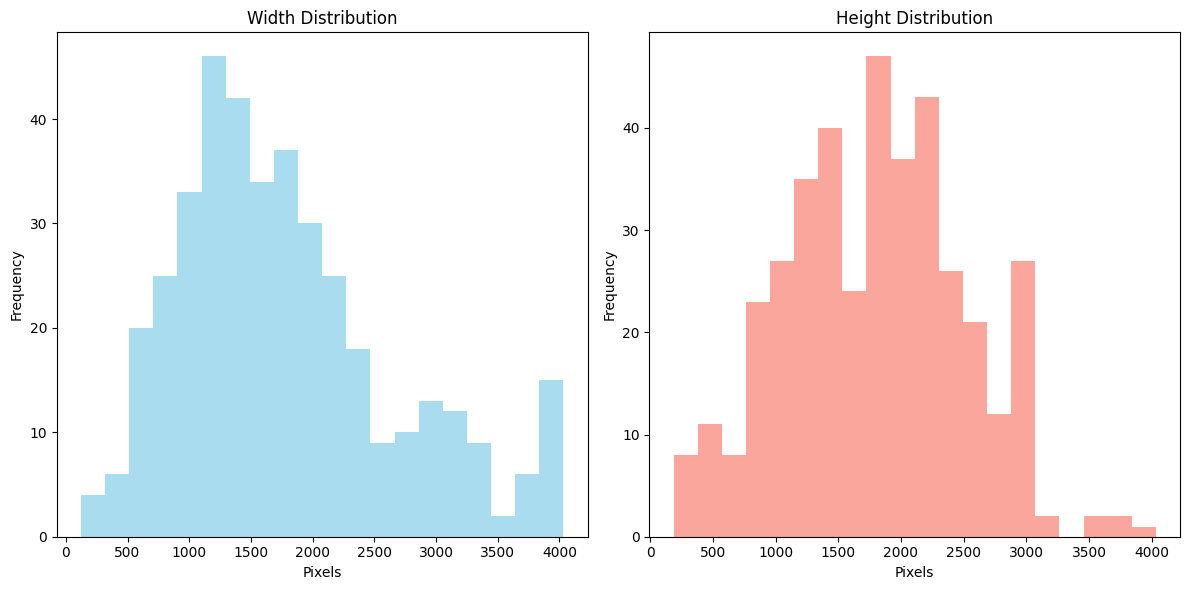

In [4]:
# Original image size distribution, to compare how the resizing affects the images with compression
def collect_image_sizes(base_folder):
    original_sizes = []
    for folder in ['toast', 'mena']:
        folder_path = os.path.join(base_folder, folder)
        for filename in os.listdir(folder_path):
            if not filename.startswith('.'):
                image_path = os.path.join(folder_path, filename)
                image = cv2.imread(image_path)
                if image is not None:
                    # Collect only height and width
                    original_sizes.append(image.shape[:2])  
    return original_sizes

# Collect original sizes from the images
base_folder = './cats'
original_sizes = collect_image_sizes(base_folder)

# Extract width and height
widths, heights = zip(*original_sizes)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(widths, bins=20, color='skyblue', alpha=0.7)
ax1.set_title('Width Distribution')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('Frequency')

ax2.hist(heights, bins=20, color='salmon', alpha=0.7)
ax2.set_title('Height Distribution')
ax2.set_xlabel('Pixels')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Color Channel Distributions

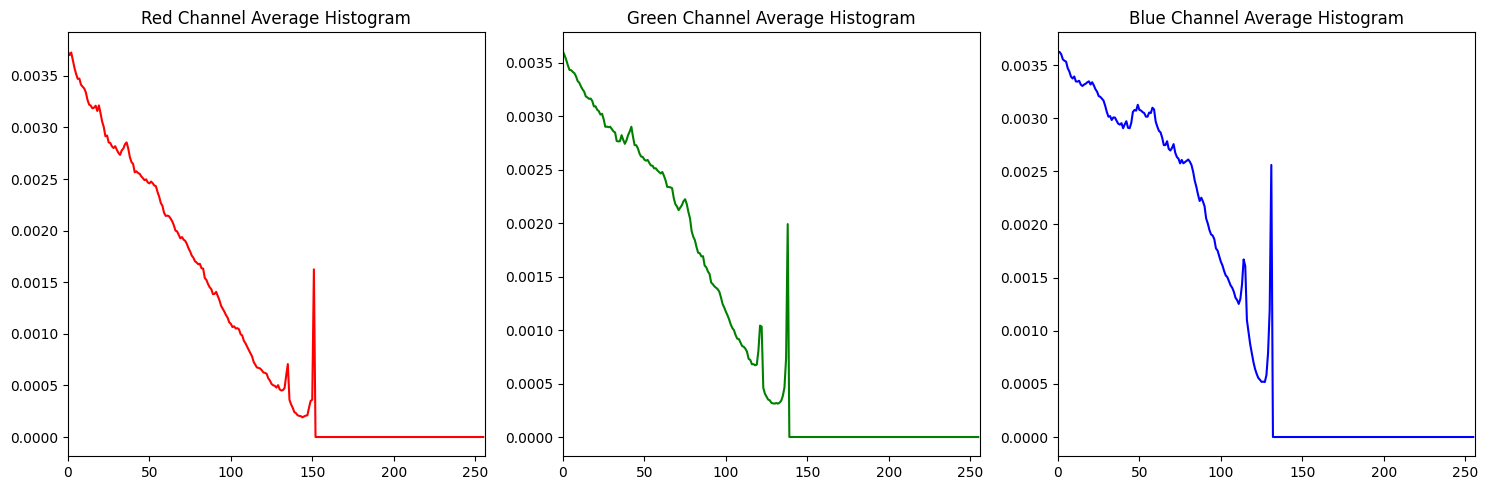

In [5]:
def plot_average_histograms(image_array):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    color_labels = ['Red Channel', 'Green Channel', 'Blue Channel']
    colors = ['r', 'g', 'b']

    # Initialize histograms
    average_hist = [np.zeros(256) for _ in range(3)]

    # Accumulate histograms from all images
    for img in image_array:
        for i in range(3):
            hist, bins = np.histogram(img[..., i].ravel(), bins=256, range=[0, 256])
            average_hist[i] += hist

    # Normalize and plot histograms
    for i, color in enumerate(colors):
        average_hist[i] = average_hist[i] / (image_array.shape[0] * image_array.shape[1] * image_array.shape[2])
        axes[i].plot(average_hist[i], color=color)
        axes[i].set_title(f'{color_labels[i]} Average Histogram')
        axes[i].set_xlim([0, 256])

    plt.tight_layout()
    plt.show()

# Plot average histograms
plot_average_histograms(preprocessed_images)  

### Pixel Intensity Distribution

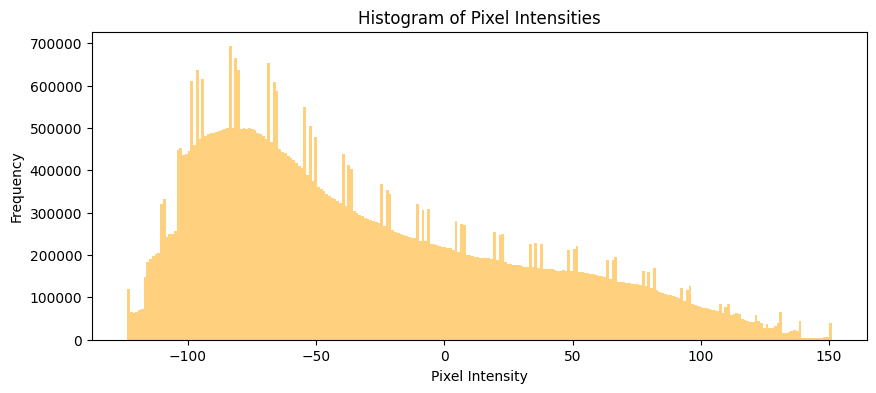

In [6]:
# Histogram of pixel intensities
plt.figure(figsize=(10, 4))
plt.hist(preprocessed_images.ravel(), bins=256, color='orange', alpha=0.5)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Intensities')
plt.show()

### Pixel Intensity Outliers

In [7]:
# Identifying outliers by extreme average brightness
brightness = np.mean(preprocessed_images, axis=(1, 2, 3))
brightness_threshold = np.percentile(brightness, [5, 95])
outliers = np.where((brightness < brightness_threshold[0]) | (brightness > brightness_threshold[1]))[0]

print(f'Outlier indices: {outliers}')
print(f"Number of outliers: {len(outliers)}")


Outlier indices: [  7  19  24  25  26  31  33  56  58  74  88  97 100 111 120 122 126 129
 131 149 159 172 193 207 228 236 237 250 251 259 272 285 332 334 343 345
 349 379 380 390]
Number of outliers: 40


### Texture Analysis

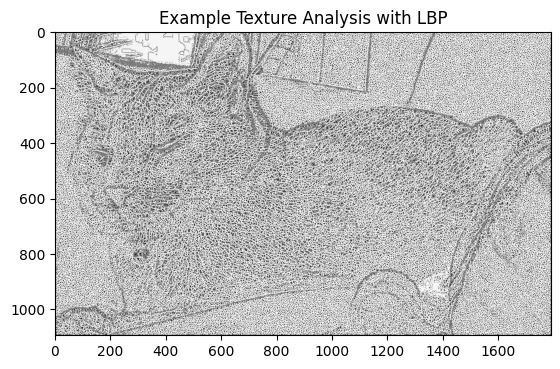

In [8]:
# Display texture features of an example image using LBP from scikit-image
radius = 3
n_points = 8 * radius

def compute_lbp(image):
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    return lbp

# Load image and convert to grayscale
image = io.imread(image_paths[0])  
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  
lbp_image = compute_lbp(image_gray)

plt.imshow(lbp_image, cmap='gray')
plt.title("Example Texture Analysis with LBP")
plt.show()

### Hypothesis from EDA 

Based on the features we explored, we can make the following hypotheses:

- The image color distriutions could be different for Toast and Mena due to their different fur colors.
- The pixel intensity distibution may not be significantly different between the two cats, as the images are all from different scenarios which may not have a consistent pixel intensity distribution.
- The texture analysis may show some differences between the two cats, as their fur textures are different and their face shapes are different.
- The height and width of the images may have been affected by the resizing process, but the aspect ratio should be consistent across all images.

All image feature extractions from the pre-trained neural network will be done on the preprocessed images, and thus should find some of these nuances when adjusting the pre-trained model for feature exctraction on our dataset to aid in better clustering. 

# Feature Extraction

In this project we will be using feature extraction from a pre-trained neural network to extract features from the images. These features will be used for dimensionality reduction and the unsupervised clustering of the images.

## Preprocessing
Before feature extraction, we perform several preprocessing steps to ensure our data is suitable for input into a neural network model:

1. **Label Encoding**: Convert categorical string labels (cat names) to numerical values for compatibility with the model.
2. **Data Splitting**: Divide the dataset into training and validation sets to evaluate the model's performance on unseen data.

## Model Setup
For feature extraction, we utilize a pre-trained ResNet152 model, which is renowned for its powerful image recognition capabilities.

### Model Configuration
- **Base Model**: ResNet152 with ImageNet pre-trained weights, excluding the top layer to allow for custom modifications.
- **Custom Layers**:
  - `GlobalAveragePooling2D`: Reduces dimensionality and extracts essential features.
  - `Dense`: Adds a dense layer with 256 neurons, using ReLU activation for non-linearity.
  - `Output Layer`: A single neuron with sigmoid activation for binary classification.

### Model Compilation
- **Optimizer**: Adam with a learning rate of 0.0001.
- **Loss Function**: Binary crossentropy, suitable for binary classification tasks.
- **Metrics**: Accuracy, to track the performance of the model during training.

## Training
The model is trained for 10 epochs with a batch size of 32, using the training dataset and validating on the validation set.

## Feature Extraction
Post-training, we utilize the model, excluding the final output layer, to extract features from the images. This modified model outputs the activations from the last dense layer (`Dense(256, activation='relu')`), providing a rich representation of the input images.

## Output
**The extracted features are stored in an array, which can be used for further analysis or as input to our unsupervised clustering algorithm.**

In [9]:
# Create an array of labels
labels = np.array(labels)

# Encode the string labels into numerical labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    preprocessed_images, labels, test_size=0.2, random_state=12
)


# Load the pre-trained ResNet152 model for feature extraction
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the fine tuned model
model = Model(inputs=base_model.input, outputs=outputs)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=32)

# Create the fine-tuned model for feature extraction
model_features = Model(inputs=base_model.input, outputs=x)

# Extract features using the modified model
features = model_features.predict(preprocessed_images)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5189 - loss: 0.7607 - val_accuracy: 0.9000 - val_loss: 0.3333
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9426 - loss: 0.2663 - val_accuracy: 0.9375 - val_loss: 0.1928
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9741 - loss: 0.1382 - val_accuracy: 0.9750 - val_loss: 0.1109
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9973 - loss: 0.0720 - val_accuracy: 0.9875 - val_loss: 0.0827
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9983 - loss: 0.0461 - val_accuracy: 0.9875 - val_loss: 0.0669
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 0.0350 - val_accuracy: 1.0000 - val_loss: 0.0548
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 0.0273 - val_accuracy: 0.9875 - val_loss: 0.0518
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 0.0186 - val_accuracy: 0.9875 - val_loss:

# Dimensionality Reduction and Clustering 

The next section comprises of the main focus in this project, which is the dimensionality reduction and clustering of the extracted features. These unsupervised techniques can help us group the images into clusters based on their visual characteristics, which were extracted from features in the pre-trained neural network.

We will be comparing two different methods for clustering KMeans and DBSCAN. For KMeans we will be using PCA for dimensionality reduction, tuning for the optimal number of components. For DBSCAN we will be tuning the epsilon and min_samples parameters for optimal clustering as well.

### Optimize KMeans Clustering

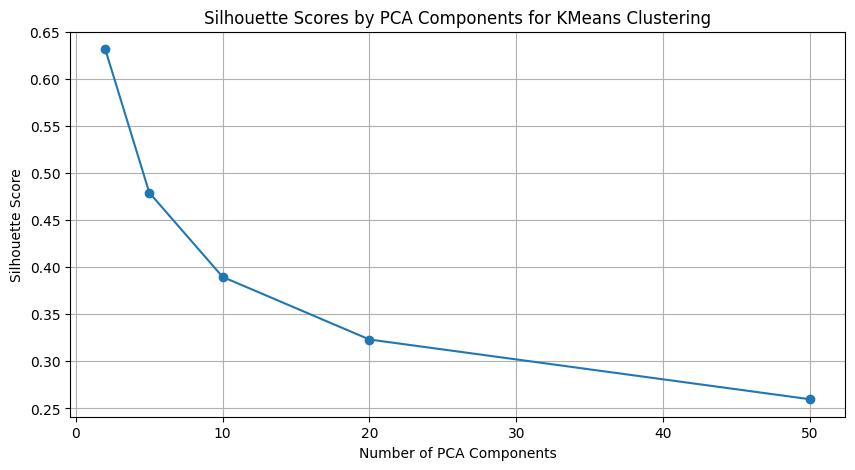

The optimal number of PCA components based on the silhouette score is: 2
 Top Silhouette Score: 0.63


In [10]:
# PCA components to test
n_components = [2, 5, 10, 20, 50]
silhouette_scores = []

for n in n_components:
    pca = PCA(n_components=n, random_state=12)  
    reduced_features = pca.fit_transform(features)
    
    kmeans = KMeans(n_clusters=2, random_state=12)
    clusters = kmeans.fit_predict(reduced_features)
    
    # Calculate silhouette score
    if len(set(clusters)) > 1:  
        score = silhouette_score(reduced_features, clusters)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  

plt.figure(figsize=(10, 5))
plt.plot(n_components, silhouette_scores, marker='o')
plt.title('Silhouette Scores by PCA Components for KMeans Clustering')
plt.xlabel('Number of PCA Components')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Optimal number of components
optimal_n = n_components[silhouette_scores.index(max(silhouette_scores))]
print(f"The optimal number of PCA components based on the silhouette score is: {optimal_n}")
print(f" Top Silhouette Score: {max(silhouette_scores):.2f}")


Based on the results above, the optimal number of components for PCA in KMeans is 2. 

### Optimize DBSCAN Hyperparameters

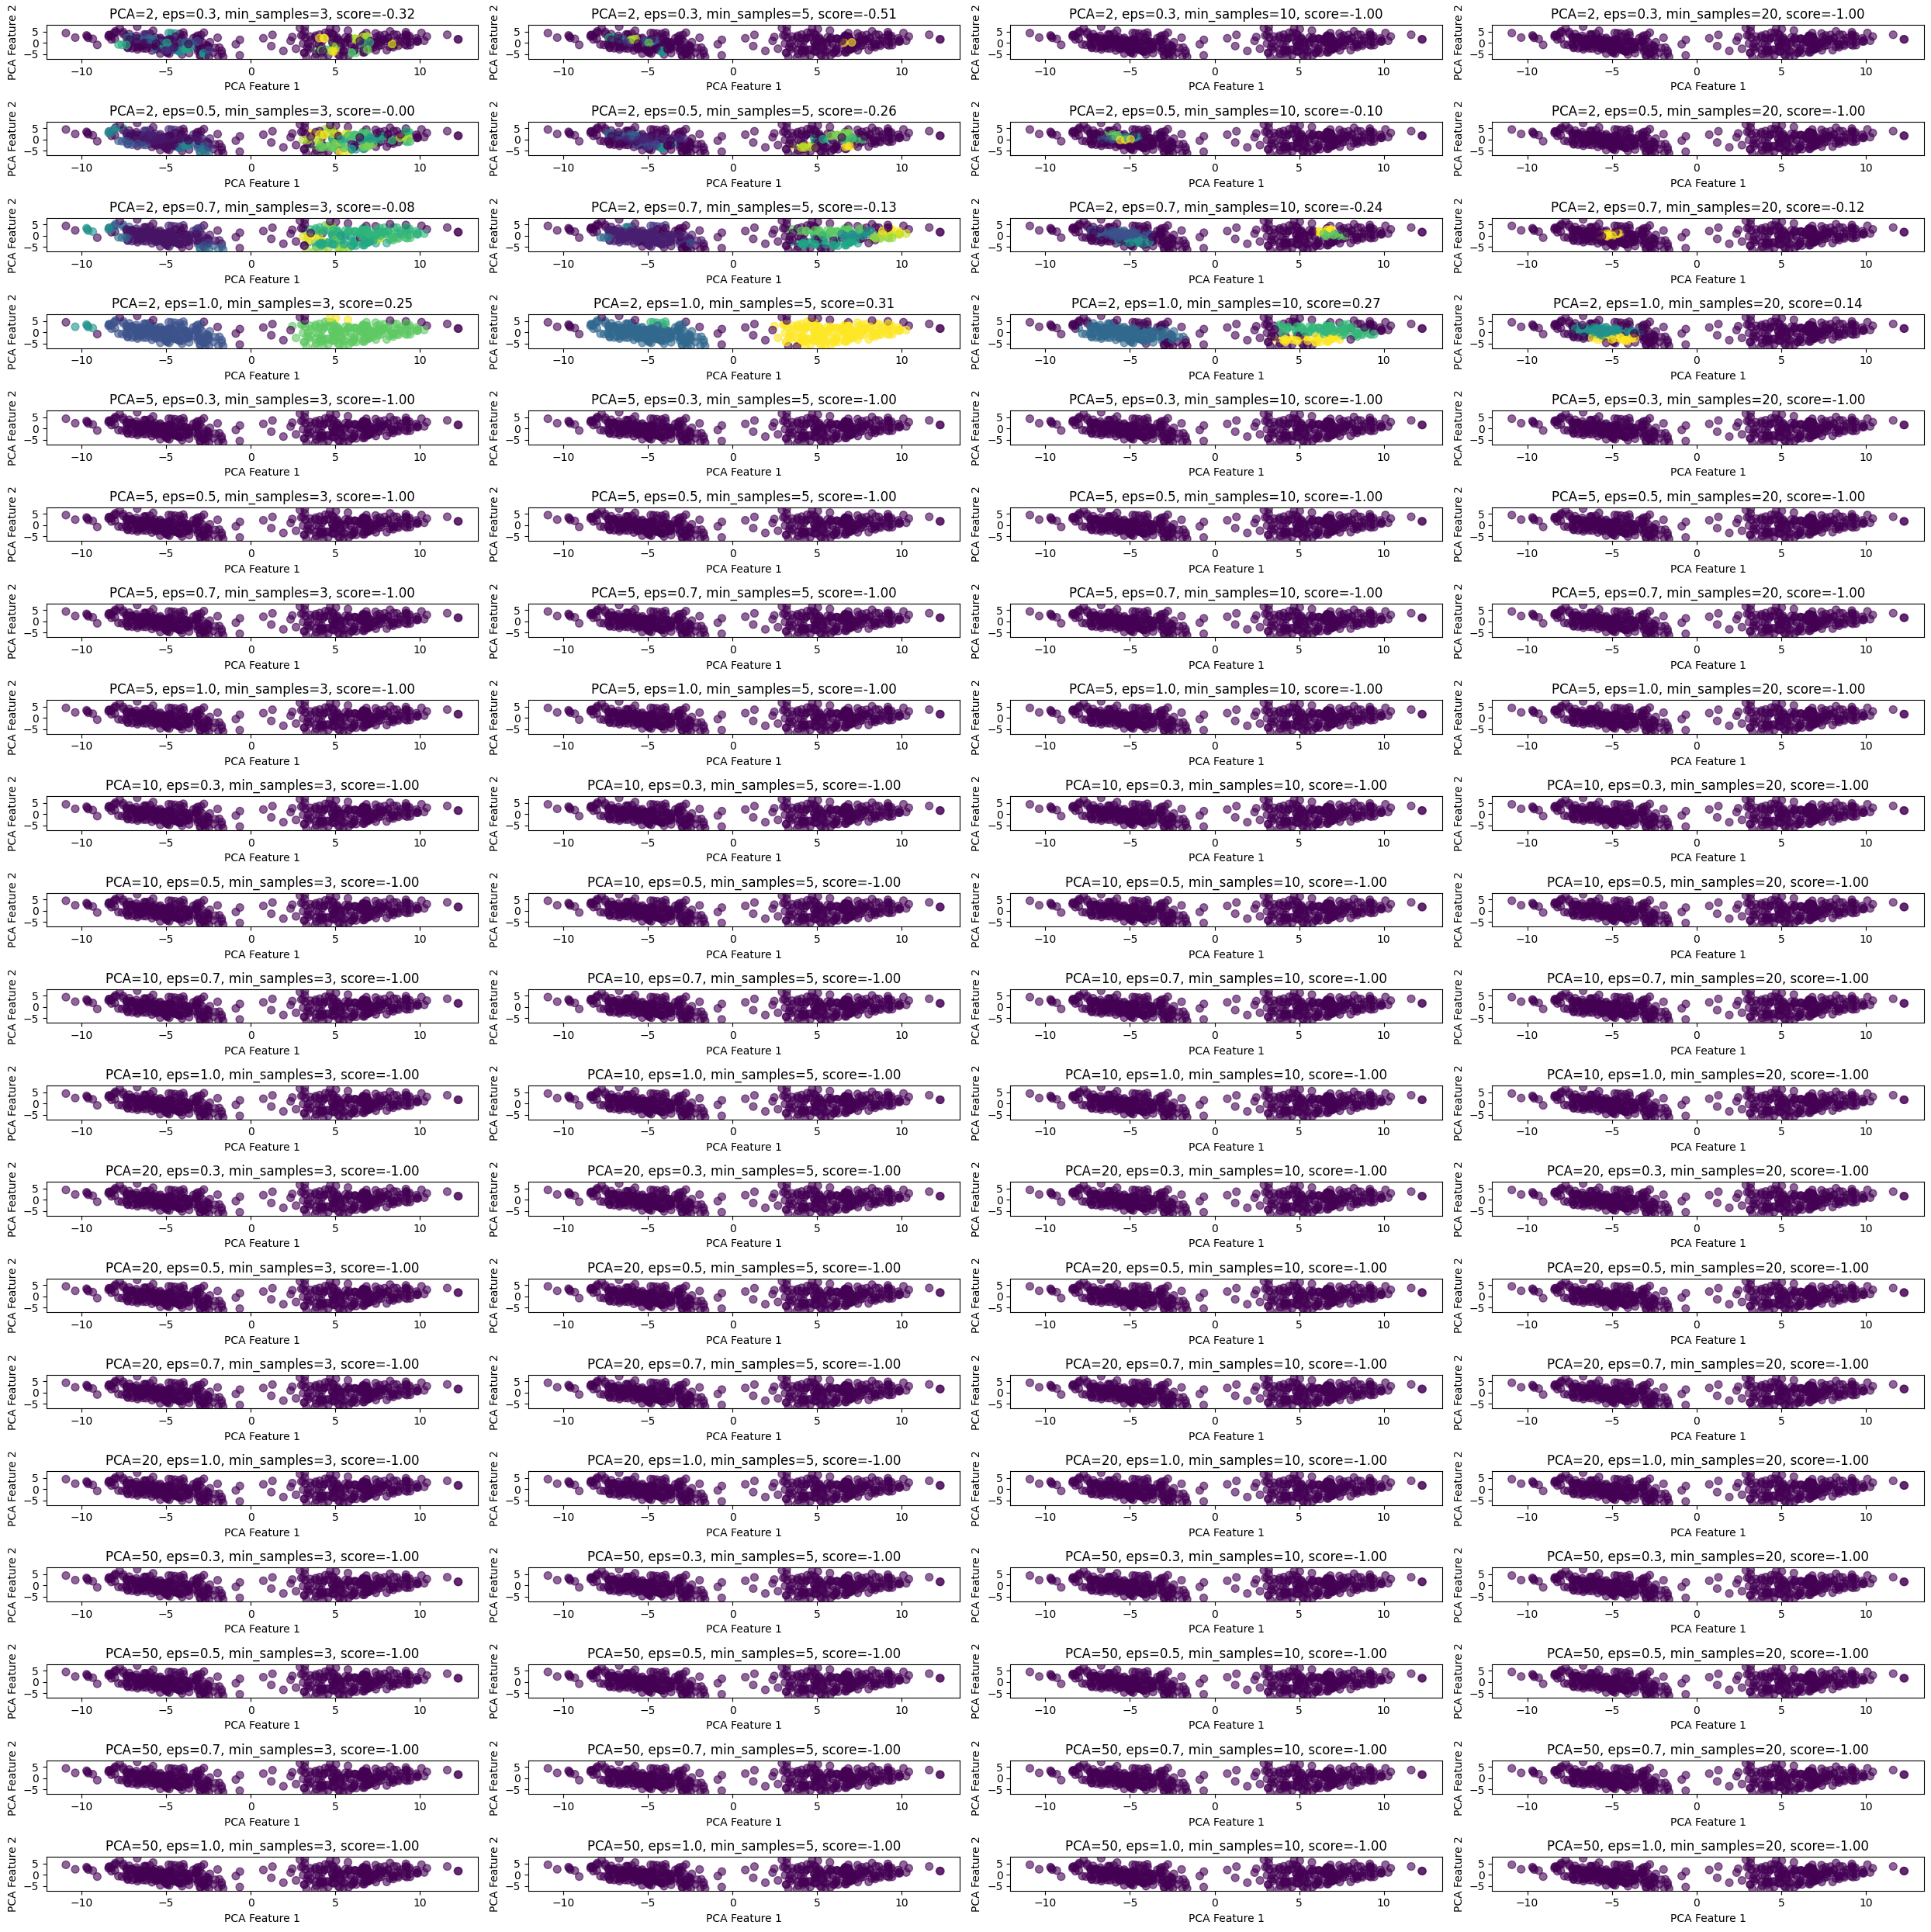

Best parameters: PCA n_components=2, DBSCAN eps=1.0, min_samples=5 with Silhouette Score: 0.31


In [19]:
# PCA and DBSCAN parameters
n_components_values = [2, 5, 10, 20, 50]
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 10, 20]
best_score = -1
best_params = None

# Create subplots for each combination of parameters
fig, axs = plt.subplots(len(n_components_values) * len(eps_values), len(min_samples_values), figsize=(25, 25))

# Loop over combinations of PCA and DBSCAN parameters
for i, n_components in enumerate(n_components_values):
    for j, eps in enumerate(eps_values):
        for k, min_samples in enumerate(min_samples_values):
            pca = PCA(n_components=n_components, random_state=12)
            pca_features = pca.fit_transform(features)

            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(pca_features)

            if len(set(clusters)) > 1:
                silhouette_avg = silhouette_score(pca_features, clusters)
            else:
                silhouette_avg = -1  

            ax = axs[i * len(eps_values) + j, k]
            ax.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='viridis', marker='o', s=50, alpha=0.6)
            ax.set_title(f'PCA={n_components}, eps={eps}, min_samples={min_samples}, score={silhouette_avg:.2f}')
            ax.set_xlabel('PCA Feature 1')
            ax.set_ylabel('PCA Feature 2')

            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_params = (n_components, eps, min_samples)

plt.tight_layout()
plt.show()

print(f"Best parameters: PCA n_components={best_params[0]}, DBSCAN eps={best_params[1]}, min_samples={best_params[2]} with Silhouette Score: {best_score:.2f}")



Based on the DBSCAN clustering it looks like from both in the plots and within the scored data, the optimal components for the PCA is 2. The eps = 1.0 and min_samples = 5 for the DBSCAN clustering. The silhouette score for the DBSCAN clustering is 0.31.

Compared to the KMeans silhoutte the DBSCAN is lower than the .63 achieved with KMeans. We will compare the accuracy of clustering the images, but I suspect that the KMeans will have a higher accuracy due to the higher silhouette score and only 2 classes of cats since we have only two cats.

## Comparing Model Accuracy 

Now that we have optimized the hyperparameters in the models, now we will compare the accuracy of the models to ultimately pick one as a final model. 

In [21]:
# Apply PCA for dimensionality reduction with the optimal number of components
pca = PCA(n_components=2, random_state=12)
reduced_features = pca.fit_transform(features)

# Apply DBSCAN clustering with the tuned parameters
dbscan = DBSCAN(eps=1.0, min_samples=5)
dbscan_clusters = dbscan.fit_predict(reduced_features)

# Count the number of images from each folder in each cluster
dbscan_cluster_counts = {}
for cluster_id in np.unique(dbscan_clusters):
    dbscan_cluster_counts[cluster_id] = {'toast': 0, 'mena': 0}

for image_path, cluster_id in zip(image_paths, dbscan_clusters):
    folder = os.path.basename(os.path.dirname(image_path))
    if cluster_id in dbscan_cluster_counts:
        dbscan_cluster_counts[cluster_id][folder] += 1

# Print the number of images from each folder in each cluster
print("Number of images from each folder in each DBSCAN cluster:")
for cluster_id, counts in dbscan_cluster_counts.items():
    print(f"Cluster {cluster_id}:")
    for folder, count in counts.items():
        print(f"  {folder}: {count} images")

# Calculate silhouette score for DBSCAN
if len(set(dbscan_clusters)) > 1:  
    silhouette = silhouette_score(reduced_features, dbscan_clusters)
    print(f"Silhouette Score for DBSCAN: {silhouette}")
else:
    print("DBSCAN resulted in less than two clusters, silhouette score cannot be calculated.")

total_images = len(preprocessed_images)
print(f"Total number of images classified with DBSCAN: {total_images}")

print()
print()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=12)
clusters = kmeans.fit_predict(reduced_features)

# Count the number of images from each folder in each cluster
cluster_counts = {}
for cluster_id in np.unique(clusters):
    cluster_counts[cluster_id] = {'toast': 0, 'mena': 0}

for image_path, cluster_id in zip(image_paths, clusters):
    folder = os.path.basename(os.path.dirname(image_path))
    cluster_counts[cluster_id][folder] += 1

print("Number of images from each folder in each KMeans cluster:")
for cluster_id, counts in cluster_counts.items():
    print(f"Cluster {cluster_id}:")
    for folder, count in counts.items():
        print(f"  {folder}: {count} images")

# Calculate silhouette score for KMeans
silhouette = silhouette_score(reduced_features, clusters)
print(f"Silhouette Score for KMeans: {silhouette}")

total_images = len(preprocessed_images)
print(f"Total number of images classified with KMeans: {total_images}")

Number of images from each folder in each DBSCAN cluster:
Cluster -1:
  toast: 15 images
  mena: 21 images
Cluster 0:
  toast: 194 images
  mena: 0 images
Cluster 1:
  toast: 6 images
  mena: 0 images
Cluster 2:
  toast: 0 images
  mena: 160 images
Silhouette Score for DBSCAN: 0.30742719769477844
Total number of images classified with DBSCAN: 396


Number of images from each folder in each KMeans cluster:
Cluster 0:
  toast: 215 images
  mena: 0 images
Cluster 1:
  toast: 0 images
  mena: 181 images
Silhouette Score for KMeans: 0.6315871477127075
Total number of images classified with KMeans: 396


# Chosen Clustering Method 

Based on the model tuning above we will be moving forward with the KMeans clustering method with PCA for dimensionality reduction. This model had 100% accuracy in clustering the images of the two cats correctly as opposed to the DBSCAN model which had a lower silhouette score and a lower accuracy in clustering the images. This model also has a higher silhouette score than the DBSCAN model, and thus will be better for predicting clusters in new images. 

In [22]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=12)  
reduced_features = pca.fit_transform(features)

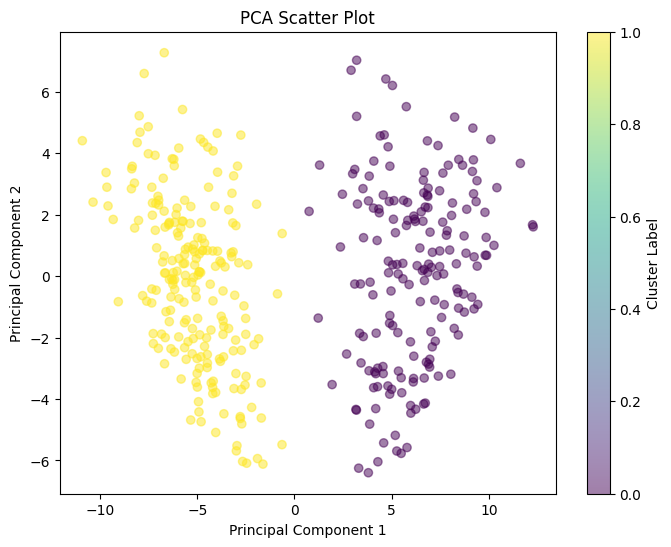

In [23]:
# Plot the PCA scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.colorbar(label='Cluster Label')
plt.show()

# Final Model

In [24]:
# Apply KMeans clustering

kmeans = KMeans(n_clusters=2, random_state=12)
clusters = kmeans.fit_predict(reduced_features)

# Count the number of images from each folder in each cluster
cluster_counts = {}
for cluster_id in np.unique(clusters):
    cluster_counts[cluster_id] = {'toast': 0, 'mena': 0}

for image_path, cluster_id in zip(image_paths, clusters):
    folder = os.path.basename(os.path.dirname(image_path))
    cluster_counts[cluster_id][folder] += 1

print("Number of images from each folder in each cluster:")
for cluster_id, counts in cluster_counts.items():
    print(f"Cluster {cluster_id}:")
    for folder, count in counts.items():
        print(f"  {folder}: {count} images")

# Print the total number of images classified
total_images = len(preprocessed_images)
print(f"Total number of images classified: {total_images}")


Number of images from each folder in each cluster:
Cluster 0:
  toast: 215 images
  mena: 0 images
Cluster 1:
  toast: 0 images
  mena: 181 images
Total number of images classified: 396


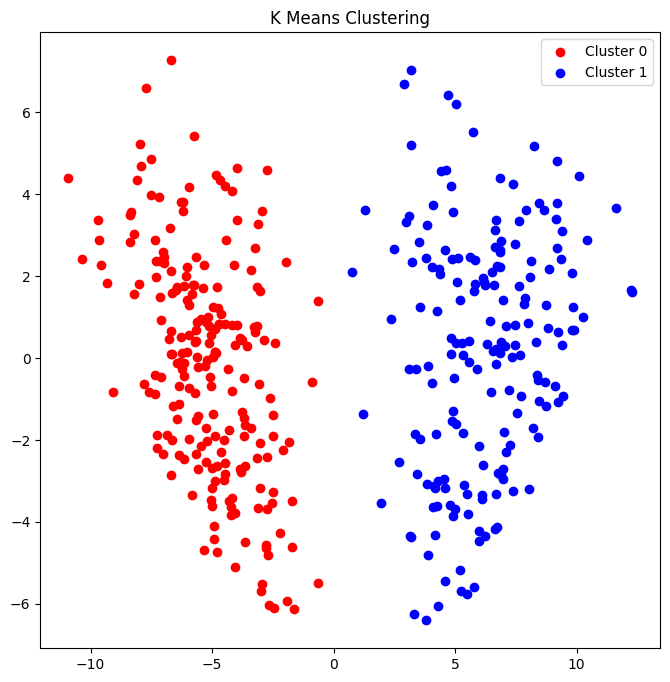

In [25]:
# Visualize the clusters
plt.figure(figsize=(8, 8))
for cluster_id in np.unique(clusters):
    if cluster_id == -1:
        # Outliers marked as gray
        color = 'gray'
    else:
        color = ['red', 'blue'][cluster_id % 2]
    mask = clusters == cluster_id
    plt.scatter(reduced_features[mask, 0], reduced_features[mask, 1], c=color, label=f'Cluster {cluster_id}')
plt.legend()
plt.title('K Means Clustering')
plt.show()

## Now finally you get to see more images of my cats!

I hope you enjoyed reviewing my project and seeing how much fun unsupervised learning can be when you get to work with your own data.

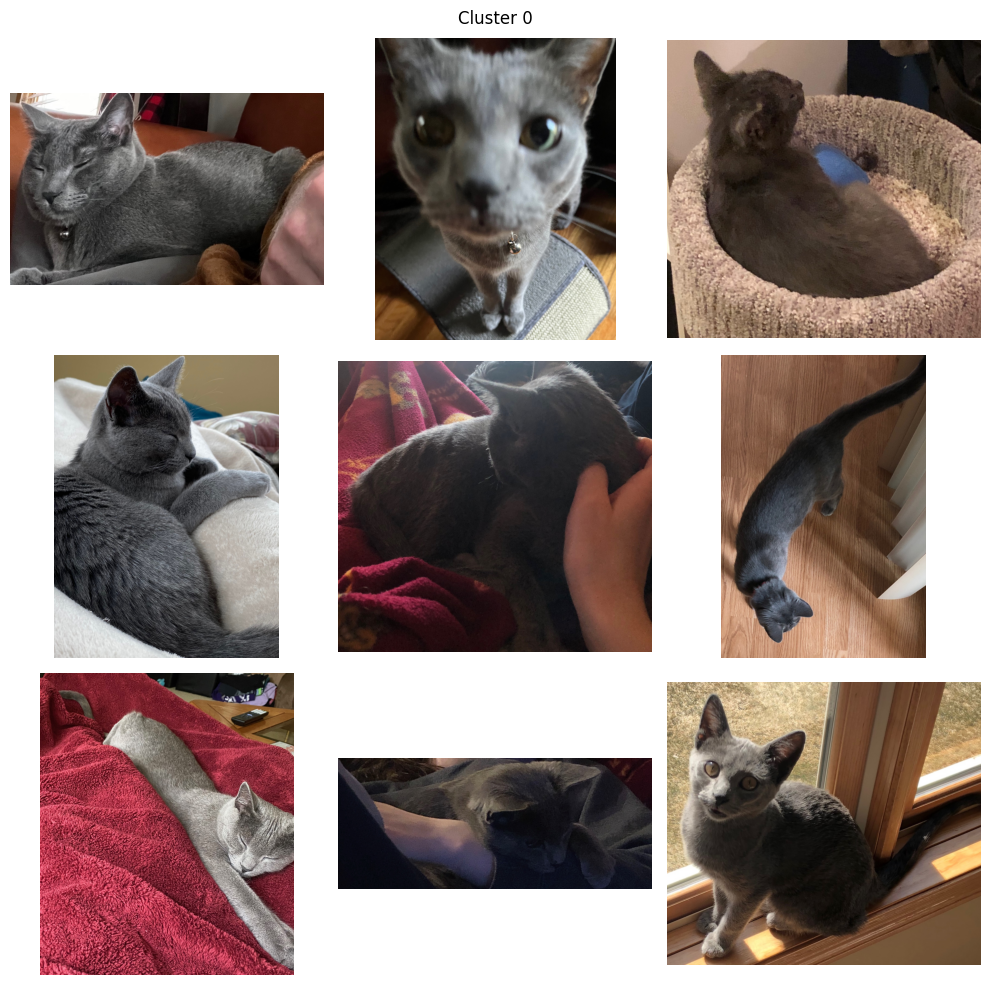

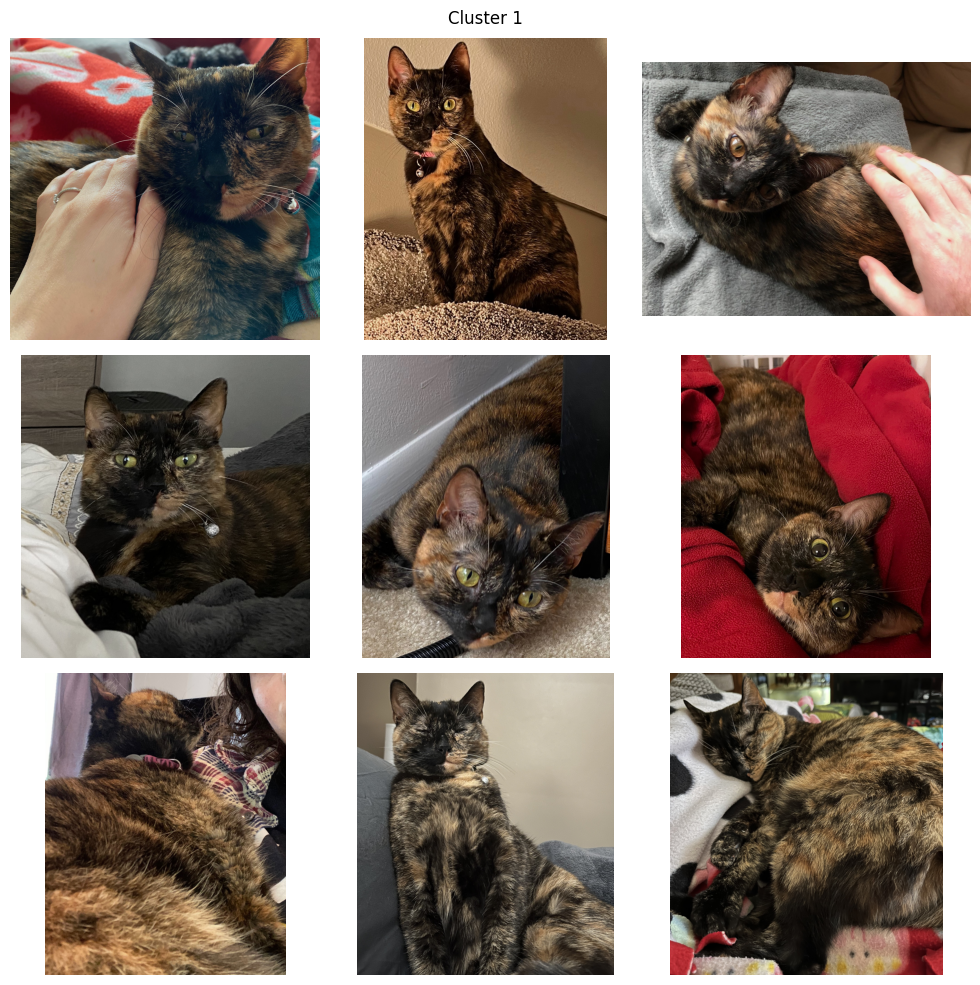

In [26]:
# Show example images from each cluster
for cluster_id in np.unique(clusters):
    cluster_images = [image_paths[i] for i in range(len(image_paths)) if clusters[i] == cluster_id]
    plt.figure(figsize=(10, 10))
    for i, image_path in enumerate(cluster_images[:9]):
        plt.subplot(3, 3, i + 1)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis('off')
    plt.suptitle(f'Cluster {cluster_id}')
    plt.tight_layout()
    plt.show()